# Assignment2_570_youranli

In [276]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import graphviz as gr
from tqdm import tqdm
import csv
random.seed(10)

In [277]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)
# Note this is equivalent to np.var(Yt,ddof)

In [278]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    # generate random normal distribution
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


In [279]:
def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)


# 1.Covariates

In [280]:
# Step1:simulate DGP

def fn_generate_data_cov(tau,N,p,p0,corr,flagX):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 
    corr = 0.5 

        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+err
    
    if flagX==1:
        return (Yab,T)
    elif flagX==2:
        return (Yab,T,X)

In [281]:
tau = 4
corr = 0.5
p = 10
p0 = 10
N = 1000
flagX = 2
Yab,T,X = fn_generate_data_cov(tau,N,p,p0,corr,flagX)

with open('covariates.csv', 'w') as out_file: 
    writer = csv.writer(out_file)
    writer.writerow(['Yab', 'T', 'X'])
    for k in range(len(Yab)): 
        writer.writerow([Yab[k], T[k], X[k]])

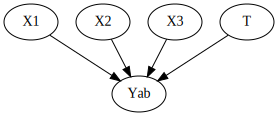

In [282]:
# step2: DOG

g = gr.Digraph()
g.edge("X1", "Yab")
g.edge("X2", "Yab")
g.edge("X3", "Yab")
g.edge("T", "Yab")
g

In [283]:
# step3: Monte Carlo experiment

In [284]:
## a. don't control for any covariates

# the function of DGP: fn_generate_data_cov(tau,N,p,p0,corr,flagX)
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        flagX = 1
        Yexp,T = fn_generate_data_cov(4,N,10,10,corr,flagX)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:14<00:00, 139.63it/s]


In [285]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    

N=100: bias=-0.38507366286329675, RMSE=8.23904937508927, size=0.0545
N=1000: bias=-0.034051557507883946, RMSE=2.4958932267195557, size=0.047


In [286]:
## b. control for all the covariates that affect the outcome

# the function of DGP: fn_generate_data_cov(tau,N,p,p0,corr,flagX)
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        flagX = 2
        Yexp,T,X = fn_generate_data_cov(4,N,10,10,corr,flagX)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:16<00:00, 121.77it/s]


In [287]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    

N=100: bias=-0.0010645805571140555, RMSE=0.14753443939729613, size=0.051
N=1000: bias=0.0001668813614081659, RMSE=0.04585043035326293, size=0.057


By comparison, we can find that after controlling other relevant covariates in the model, the bias of parameter estimation for treatment decreases significantly and gradually approaches zero. Moreover, the larger the sample size, the smaller the error of estimation.

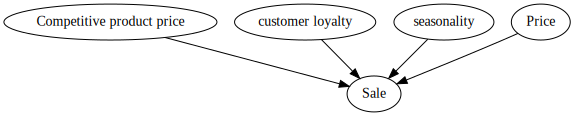

In [288]:
# step4: example of covariates

g = gr.Digraph()
g.edge("Competitive product price", "Sale")
g.edge("customer loyalty", "Sale")
g.edge("seasonality", "Sale")
g.edge("Price", "Sale")
g

For example, we want to estimate the effect of product price on sales volume. In addition to the Price of the product itself, we should also consider user loyalty, seasonality of the product and price of competitive products, etc., which will affect the sales of the product at the same time.

# 2. Confounders(common reason)

In [289]:
# Step1:simulate DGP

def fn_generate_data_con(tau,N,p,corr,flagC):

    nvar = p+1
    corr = 0.5
    
    allX = fn_generate_multnorm(N,corr,nvar)
    C = allX[:,1].reshape([N,1])
    T = fn_randomize_treatment(N,p=0.5) # choose treated units
    err = np.random.normal(0,1,[N,1])
    Tcon = T+0.3*C
    Yc = tau*Tcon+0.6*C+err
    
    if flagC==1:
        return (Yc,Tcon)
    elif flagC==2:
        return (Yc,Tcon,C)


In [290]:
tau = 4
corr = 0.5
N = 1000
p = 10
flagC = 2
Yc,Tcon,C = fn_generate_data_con(tau,N,p,corr,flagC)

with open('confouders.csv', 'w') as out_file: 
    writer = csv.writer(out_file)
    writer.writerow(['Yc', 'Tcon', 'C'])
    for k in range(len(Yab)): 
        writer.writerow([Yc[k], Tcon[k], C[k]])

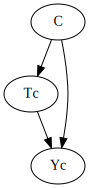

In [291]:
#step2: DOG

g = gr.Digraph()
g.edge("C", "Tc")
g.edge("C", "Yc")
g.edge("Tc", "Yc")
g

In [292]:
# step3: Monte Carlo experiment

In [293]:
## a. don't control for the confounder
# the function of DGP: fn_generate_data_con(tau,N,p,p0,corr,flagC)

estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        flagC = 1
        Yexp,T = fn_generate_data_con(tau,N,p,corr,flagC)
        covars = np.concatenate([T],axis = 1)
        mod = sm.OLS(Yexp,T)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:15<00:00, 130.01it/s]


In [294]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    

N=100: bias=0.30099598876539174, RMSE=0.3469600483044659, size=0.5495
N=1000: bias=0.3028854198393217, RMSE=0.32246815946754315, size=0.97


In [295]:
## b. control for the confounder
# the function of DGP: fn_generate_data_con(tau,N,p,corr,flagC)

estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        flagC = 2
        Yexp,T,C =  fn_generate_data_con(tau,N,p,corr,flagC)
        covars = np.concatenate([T,C],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:15<00:00, 131.10it/s]


In [296]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.008328061536482863, RMSE=0.14175732376187872, size=0.0545
N=1000: bias=-0.0004065027155505163, RMSE=0.04405831828803079, size=0.051


After controlling confounder, the bias of parameter estimation and Root Mean Square Error were both reduced. It can be seen that the accuracy of parameter estimation is improved by increasing the sample size and controlling confounder.

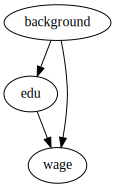

In [297]:
#step4: example of confouders

g = gr.Digraph()
g.edge("background", "edu")
g.edge("background", "wage")
g.edge("edu", "wage")
g

For example, when we measure the impact of education on wage, we should consider the sample's family background, such as the social status of parents and other factors. People from privileged backgrounds are more likely to receive better education and earn higher wages with the help of their family background.

# 3. Selection Bias (variable of the path)

In [307]:
# Step1:simulate DGP

def fn_generate_data_sb(tau,N,p,corr,flagB):

    nvar = p+2
    corr = 0.5
    
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) 
    C = allX[:,1].reshape([N,1]) 
    X = allX[:,2:] 
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    u = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    ran = random.sample(range(N), round(N*0.5))
    B = np.array([(1 if i in ran and T[i]==1 else 0) for i in range(N)]).reshape([N,1])
    
    Vb = B + 50*T + u
    Yb = 0.0001*Vb + err + tau*T
    
    if flagB==1:
        return (Yb,T)
    elif flagB==2:
        return (Yb,T,Vb)

In [308]:
tau = -20
p = 10
N = 1000
corr = 0.5
flagB = 2
Yb,T,Vb = fn_generate_data_sb(tau,N,p,corr,flagB)

with open('selection bias.csv', 'w') as out_file: 
    writer = csv.writer(out_file)
    writer.writerow(['Yb', 'T', 'Vb'])
    for k in range(len(Yab)): 
        writer.writerow([Yb[k], T[k], Vb[k]])

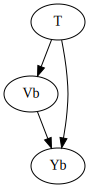

In [309]:
# step2: DOG
g = gr.Digraph()
g.edge("T", "Vb")
g.edge("T", "Yb")
g.edge("Vb", "Yb")
g

In [310]:
# step3: Monte Carlo experiment

In [311]:
# a. control for the variable in between the path from cause to effect
# the function of DGP: fn_generate_data_sb(tau,N,p,corr,flagB)

estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        flagB = 2
        Yexp,T,Vb = fn_generate_data_sb(tau,N,p,corr,flagB)
        covars = np.concatenate([T,Vb],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
    
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:29<00:00, 68.58it/s]


In [312]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.08756426750731418, RMSE=4.63829916913248, size=0.049
N=1000: bias=0.09384961118131882, RMSE=1.5167065622310856, size=0.0535


In [313]:
## b. don't control for variable in between the path from cause to effect
# the function of DGP: fn_generate_data_sb(tau,N,p,corr,flagB)

estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        flagB = 1
        Yexp,T = fn_generate_data_sb(tau,N,p,corr,flagB)
        mod = sm.OLS(Yexp,T)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:26<00:00, 76.20it/s]


In [314]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.011479559456317278, RMSE=0.14221069585961824, size=0.0595
N=1000: bias=0.0042806180385771865, RMSE=0.043565894273395744, size=0.046


The only main way that a the variable of selection bias in this situation is caused by the treatment. So, it the treatment equals to 0, the variable will also equals to zero, which has been shown in the DGP. And as we see, if we control the variable, we will ignore some effects of treatment on y, resulting in inaccurate coefficient of treatment and high bias. Therefore, as the result shows, when we do not control the variable, the estimated coefficient is more accurate and the bias is smaller.


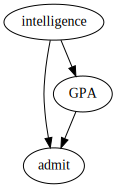

In [315]:
# step4: example of selection bias
g = gr.Digraph()
g.edge("intelligence", "admit")
g.edge("intelligence", "GPA")
g.edge("GPA", "admit")
g

For example, we wanted to study how intelligence affects the probability of college admission. If we add the GPA variable, when we analyze both grades and intelligence level, it will affect the results of the analysis. Because intelligence level can affect GPA and thus affect the probability of admission.